In [1]:
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import urllib
from tensorflow.python.framework import ops
ops.reset_default_graph()


sess=tf.Session()

In [2]:
#声明模型参数
#将训练集和测试集的批量大小设为128
batch_size=128
#每迭代50次打印出状态值
output_every=50
#迭代次数20000
generations=2000
#每迭代500次，我们将在测试集的批量数据上进行模型评估
eval_every=500
image_height=32
image_width=32
#随机裁剪图片的大小
crop_height=24
crop_width=24
#颜色分为3通道
num_channels=3
#目标分类设为10类
num_targets=10
data_dir='temp1'
#声明存储数据和批量图片的位置
extract_folder='cifar-10-batches-bin'

In [3]:
#推荐降低学习率来训练更好的模型
#采用指数级减小学习率,学习率初始值设为0.1，每迭代250次指数级减少学习率，因子为10%
learning_rate=0.1
lr_decay=0.9
num_gens_to_wait=250.
#设置读取二进制CIFA0图片的参数
image_vec_length=image_height*image_width*num_channels
record_length=1+image_vec_length

In [4]:
#设置下载CIFA-10图像数据集的URL和数据目录
data_dir='temp83'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
cifar10_url='http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
data_file=os.path.join(data_dir,'cifar-10-binary.tar.gz')
if os.path.isfile(data_file):
    pass
else:
    # Download file
    def progress(block_num, block_size, total_size):
        progress_info = [cifar10_url, float(block_num * block_size) / float(total_size) * 100.0]
        print('\r Downloading {} - {:.2f}%'.format(*progress_info), end="")
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file, progress)
    # Extract file
    tarfile.open(filepath, 'r:gz').extractall(data_dir)

In [5]:
#使用read_cifar_files()函数建立图片读取器,返回一个随机打乱的图片
def read_cifar_files(filename_queue,distort_image=True):
    reader=tf.FixedLengthRecordReader(record_bytes=record_length)
    key,record_string=reader.read(filename_queue)
    record_bytes=tf.decode_raw(record_string,tf.uint8)
    
    #Extract label
    image_label=tf.cast(tf.slice(record_bytes,[0],[1]),tf.int32)
    #Extract image
    image_extracted=tf.reshape(tf.slice(record_bytes,[1],[image_vec_length]),[num_channels,image_height,image_width])
    
    # Reshape image
    image_uint8image=tf.transpose(image_extracted,[1,2,0])
    reshaped_image=tf.cast(image_uint8image,tf.float32)
    
    #Randomly Crop image
    final_image=tf.image.resize_image_with_crop_or_pad(reshaped_image,crop_width,crop_height)
    if distort_image:
        final_image=tf.image.random_flip_left_right(final_image)
        final_image=tf.image.random_brightness(final_image,max_delta=63)
        final_image=tf.image.random_contrast(final_image,lower=0.2,upper=1.8)
        #NOrmalize whitening
        final_image=tf.image.per_image_standardization(final_image)
        return(final_image,image_label)

In [6]:
#声明批处理使用的图像管道填充函数
def input_pipeline(batch_size,train_logical=True):
    if train_logical:
        files=[os.path.join(data_dir,extract_folder,'data_batch_{}.bin'.format(i))for i in range(1,6)]
    else:
        files=[os.path.join(data_dir,extract_folder,'test_batch.bin')]
    
    filename_queue=tf.train.string_input_producer(files)
    image,label=read_cifar_files(filename_queue)
    
    min_after_dequeue=1000
    capacity=min_after_dequeue+3*batch_size
    example_batch,label_batch=tf.train.shuffle_batch([image,label],batch_size,capacity,min_after_dequeue)
    return (example_batch,label_batch)

In [7]:
#声明模型函数
#采用两个卷基层,接着使用三个全连接层
def cifar_cnn_model(input_images,batch_size,train_logical=True):
    def truncated_normal_var(name,shape,dtype):
        return (tf.get_variable(name=name,shape=shape,dtype=dtype,initializer=tf.truncated_normal_initializer(stddev=0.05)))
    def zero_var(name,shape,dtype):
        return (tf.get_variable(name=name,shape=shape,dtype=dtype,initializer=tf.constant_initializer(0.0)))
    
    #第一层卷积
    with tf.variable_scope('conv1') as scope:
        conv1_kernel=truncated_normal_var(name='conv_kernel1',shape=[5,5,3,64],dtype=tf.float32)
        conv1=tf.nn.conv2d(input_images,conv1_kernel,[1,1,1,1],padding='SAME')
        #初始化并添加偏置项
        conv1_bias=zero_var(name='conv_bias1',shape=[64],dtype=tf.float32)
        conv1_add_bias=tf.nn.bias_add(conv1,conv1_bias)
        #  Relu
        relu_conv1=tf.nn.relu(conv1_add_bias)
    #最大池化层
    pool1=tf.nn.max_pool(relu_conv1,ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME',name='pool_layer1')
        
    #局部响应归一化 LRN (Local Response Normalization)
    norm1=tf.nn.lrn(pool1,depth_radius=5,bias=2.0,alpha=1e-3,beta=0.75,name='norm1')
        
    # 第二个卷积层
    with tf.variable_scope('conv2') as scope:
        #卷积核5x5,
        conv2_kernel=truncated_normal_var(name='conv_kernel2',shape=[5,5,64,64],dtype=tf.float32)
        conv2=tf.nn.conv2d(norm1,conv2_kernel,[1,1,1,1],padding='SAME')
        #初始化 并 添加偏置项
        conv2_bias=zero_var(name='conv_bias2',shape=[64],dtype=tf.float32)
        conv2_add_bias=tf.nn.bias_add(conv2,conv2_bias)
        #Relu
        relu_conv2=tf.nn.relu(conv2_add_bias)
            
    #最大池化层
    pool2=tf.nn.max_pool(relu_conv2,ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME',name='pool_layer2')
    
    #局部响应归一化
    norm2=tf.nn.lrn(pool2,depth_radius=5,bias=2.0,alpha=1e-3,beta=.075,name='norm2')
    
    #将输出形状重新调整为单个矩阵，以便为完全连接的层进行相乘
    reshaped_output=tf.reshape(norm2,[batch_size,-1])
    reshaped_dim=reshaped_output.get_shape()[1].value
    
    
    #第一个全连接层
    with tf.variable_scope('full1')as scope:
        #全连接层有384个输出
        full_weight1=truncated_normal_var(name='full_nult1',shape=[reshaped_dim,384],dtype=tf.float32)
        full_bias1=zero_var(name='full_bias1',shape=[384],dtype=tf.float32)
        full_layer1=tf.nn.relu(tf.add(tf.matmul(reshaped_output,full_weight1),full_bias1))
        
    #第二个全连接层
    with tf.variable_scope('full2') as scope:
        #第二个全连接层有192个输出
        full_weight2=truncated_normal_var(name='full_mult2',shape=[384,192],dtype=tf.float32)
        full_bias2=zero_var(name='full_bias2',shape=[192],dtype=tf.float32)
        full_layer2=tf.nn.relu(tf.add(tf.matmul(full_layer1,full_weight2),full_bias2))
        
    #最后一层全连接层-->产生10个分类输出
    with tf.variable_scope('full3') as scope:
        full_weight3=truncated_normal_var(name='full_mult3',shape=[192,num_targets],dtype=tf.float32)
        full_bias3=zero_var(name='full_bias3',shape=[num_targets],dtype=tf.float32)
        final_output=tf.add(tf.matmul(full_layer2,full_weight3),full_bias3)
        
    return (final_output)

In [8]:
#创建损失函数
def cifar_loss(logits,targets):
    targets=tf.squeeze(tf.cast(targets,tf.int32))
    #计算交叉熵损失
    cross_entropy=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=targets)
    #计算平均损失
    cross_entropy_mean=tf.reduce_mean(cross_entropy,name='cross_entropy')
    return(cross_entropy_mean)

In [9]:
#定义训练步骤函数，在训练步骤中学习率将指数减小
def train_step(loss_value,generation_num):
    #当经过迭代后，学习率将指数衰退
    model_learning_rate=tf.train.exponential_decay(learning_rate,generation_num,num_gens_to_wait,lr_decay,staircase=True)
    
    #创建优化器
    my_optimizer=tf.train.GradientDescentOptimizer(model_learning_rate)
    #初始化训练步骤
    train_step=my_optimizer.minimize(loss_value)
    return (train_step)

In [10]:
#批量创建准确度函数
def accuracy_of_batch(logits,targets):
    #确保目标向量是integer类型，并且移除额外的维度
    targets=tf.squeeze(tf.cast(targets,tf.int32))
    #通过那个回归值最大来获取预测值
    batch_predictions=tf.cast(tf.argmax(logits,1),tf.int32)
    #检查批次是否相同
    predicted_correctly=tf.equal(batch_predictions,targets)
    
    accuracy=tf.reduce_mean(tf.cast(predicted_correctly,tf.float32))
    return(accuracy)

In [11]:
#获取数据
print('获取数据')
#初始化数据管道
images,targets=input_pipeline(batch_size,train_logical=True)
#从管道中批量获取测试图像
test_images,test_targets=input_pipeline(batch_size,train_logical=False)

#初始化训练模型
print('创建 CIFAR10 Model.')
with tf.variable_scope('model_definition') as scope:
    #声明训练网络模型
    model_output=cifar_cnn_model(images,batch_size)
    #在该范围内重复使用变量
    scope.reuse_variables()
    test_output=cifar_cnn_model(test_images,batch_size)
    
#声明损失函数
print('声明损失函数')
loss=cifar_loss(model_output,targets)

#创建精度函数
accuracy=accuracy_of_batch(test_output,test_targets)

#创建训练操作
print('创建训练操作.')
generation_num=tf.Variable(0,trainable=False)
train_op=train_step(loss,generation_num)

#初始化变量
print('初始化变量')
init=tf.global_variables_initializer()
sess.run(init)

#运行start_queue_runners()函数，启动图像管道
tf.train.start_queue_runners(sess=sess)

#训练CIFAR model
print('开始训练')
train_loss=[]
test_accuracy=[]
for i in range(generations):
    _,loss_value=sess.run([train_op,loss])
    
    if(i+1)%output_every==0:
        train_loss.append(loss_value)
        output='迭代次数 {}:Loss={:.5f}'.format((i+1),loss_value)
        print(output)
        
    if(i+1)%eval_every==0:
        [temp_accuracy]=sess.run([accuracy])
        test_accuracy.append(temp_accuracy)
        acc_output='  --  测试精度 ={:.2f}%.'.format(100.*temp_accuracy)
        print(acc_output)

获取数据
创建 CIFAR10 Model.
声明损失函数
创建训练操作.
初始化变量
开始训练
迭代次数 50:Loss=1.87833
迭代次数 100:Loss=1.88443
迭代次数 150:Loss=1.59662
迭代次数 200:Loss=1.66931
迭代次数 250:Loss=1.66828
迭代次数 300:Loss=1.47664
迭代次数 350:Loss=1.53239
迭代次数 400:Loss=1.60921
迭代次数 450:Loss=1.32321
迭代次数 500:Loss=1.40910
  --  测试精度 =42.97%.
迭代次数 550:Loss=1.41188
迭代次数 600:Loss=1.27697
迭代次数 650:Loss=1.45077
迭代次数 700:Loss=1.43395
迭代次数 750:Loss=1.17393
迭代次数 800:Loss=1.19319
迭代次数 850:Loss=1.06746
迭代次数 900:Loss=1.17391
迭代次数 950:Loss=1.27312
迭代次数 1000:Loss=1.03174
  --  测试精度 =56.25%.
迭代次数 1050:Loss=1.03347
迭代次数 1100:Loss=1.30734
迭代次数 1150:Loss=1.04994
迭代次数 1200:Loss=0.86557
迭代次数 1250:Loss=1.07776
迭代次数 1300:Loss=1.18892
迭代次数 1350:Loss=1.04428
迭代次数 1400:Loss=1.08864
迭代次数 1450:Loss=1.06254
迭代次数 1500:Loss=0.94355
  --  测试精度 =64.06%.
迭代次数 1550:Loss=0.77539
迭代次数 1600:Loss=1.10781
迭代次数 1650:Loss=0.85841
迭代次数 1700:Loss=1.06180
迭代次数 1750:Loss=1.00367
迭代次数 1800:Loss=0.83163
迭代次数 1850:Loss=0.84562
迭代次数 1900:Loss=0.91411
迭代次数 1950:Loss=1.06432
迭代次数 2000:Loss

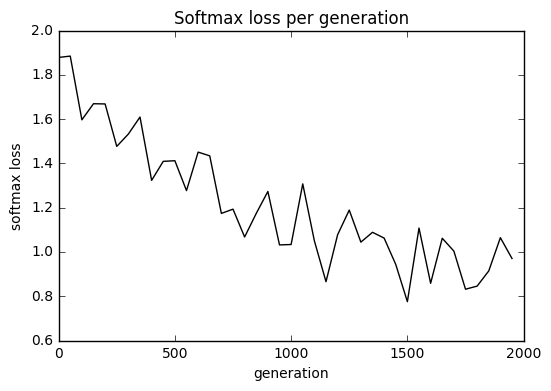

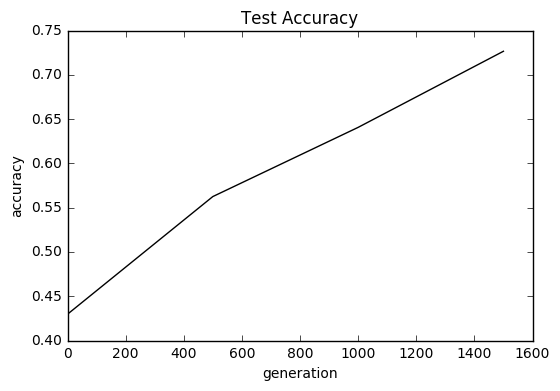

In [12]:
#打印损失和精度
eval_indices=range(0,generations,eval_every)
output_indices=range(0,generations,output_every)

plt.plot(output_indices,train_loss,'k-')
plt.title('Softmax loss per generation')
plt.xlabel('generation')
plt.ylabel('softmax loss')
plt.show()

plt.plot(eval_indices,test_accuracy,'k-')
plt.title('Test Accuracy')
plt.xlabel('generation')
plt.ylabel('accuracy')
plt.show()